In [1]:
import pandas as pd
import folium
from pyproj import Transformer
import datetime
import time

# 读取CSV轨迹点数据

In [2]:
df_ais_pts = pd.read_csv(r"G:\AIS\ais_pts.csv")
df_ais_pts

mmsi                basedatetime       lat        lon  sog    cog   
0      338999000  2021-01-04 01:20:43.000000  32.66645 -117.12025  0.0   64.9  \
1      265023000  2021-01-10 01:53:19.000000  29.16882  -94.60753  0.0  263.8   
2      367348910  2021-01-09 03:17:22.000000  42.13901  -80.08249  0.0  349.1   
3      265023000  2021-01-07 07:11:07.000000  29.16815  -94.60411  0.0   86.9   
4      338999000  2021-01-04 08:09:52.000000  32.66660 -117.12019  0.1  161.8   
...          ...                         ...       ...        ...  ...    ...   
73385  338999000  2021-01-01 19:05:13.000000  32.66653 -117.12029  0.0   86.5   
73386  338999000  2021-01-01 18:58:02.000000  32.66651 -117.12032  0.0  120.2   
73387  338999000  2021-01-01 19:07:52.000000  32.66649 -117.12023  0.0  110.3   
73388  338999000  2021-01-01 19:06:32.000000  32.66648 -117.12028  0.0  128.7   
73389  338999000  2021-01-01 18:42:52.000000  32.66654 -117.12025  0.0  125.1   

       heading  vesselname  imo  callsign  vesseltype  status  length  width   
0          511         NaN  NaN       NaN         NaN       0     NaN    NaN  \
1           83         NaN  NaN       NaN         NaN       1     NaN    NaN   
2          511         NaN  NaN       NaN         NaN       5     NaN    NaN   
3          311         NaN  NaN       NaN         NaN       1     NaN    NaN   
4          511         NaN  NaN       NaN         NaN       0     NaN    NaN   
...        ...         ...  ...       ...         ...     ...     ...    ...   
73385      511         NaN  NaN       NaN         NaN       0     NaN    NaN   
73386      511         NaN  NaN       NaN         NaN       0     NaN    NaN   
73387      511         NaN  NaN       NaN         NaN       0     NaN    NaN   
73388      511         NaN  NaN       NaN         NaN       0     NaN    NaN   
73389      511         NaN  NaN       NaN         NaN       0     NaN    NaN   

       draft  cargo transcieverclass  
0        NaN    NaN                A  
1        NaN    NaN                A  
2        NaN    NaN                A  
3        NaN    NaN                A  
4        NaN    NaN                A  
...      ...    ...              ...  
73385    NaN    NaN                A  
73386    NaN    NaN                A  
73387    NaN    NaN                A  
73388    NaN    NaN                A  
73389    NaN    NaN                A  

[73390 rows x 17 columns]

In [3]:
def timestr2sec(s,f='%Y-%m-%d %H:%M:%S.000000'):
    return time.mktime(time.strptime(s,f))

def getTrajByMMSI(mmsi):
    pts = [(timestr2sec(r["basedatetime"]),r["lon"],r["lat"]) for x,r in df_ais_pts[df_ais_pts["mmsi"]==mmsi][["basedatetime","lon","lat"]].iterrows()]
    pts.sort(key=lambda p:p[0])
    return pts

# 可视化

## 首先定义如下函数

In [4]:
def utcsec2str(s, f='%Y-%m-%d %H:%M:%S'):
    "utc秒数转换为时间字符串"
    return datetime.datetime.utcfromtimestamp(s).strftime(f)

def traj_from_wkt(the_wkt):
    "轨迹WKT字符串转换为轨迹对象"
    the_wkt = the_wkt.strip()
    data = [[float(y) for y in x.split(" ")] for x in the_wkt[the_wkt.index("(") + 1:the_wkt.index(")")].split(",")]
    return data

# 轨迹可视化风格
traj_default_folium_theme = {
    'traj_line_props': {
        'weight': 2,
        'stroke': True,
        'opacity': 0.5,
        'color': 'red'
    },
    'traj_point_props': {
        'radius': 1,
        'weight': 1,
        'color': 'green',
        'opacity': 1,
        'fill': True,
        'fillColor': 'green',
        'fillOpacity': 0.5
    }
}

# 使用Folium可视化轨迹函数
def traj_to_folium(m: folium.map,
                   traj,
                   show_line: bool = True,
                   show_point: bool = True,
                   show_pt_time_tip: bool = True,
                   zoom_to_traj:bool = False,
                   traj_line_props: dict = traj_default_folium_theme['traj_line_props'],
                   traj_point_props: dict = traj_default_folium_theme['traj_point_props']
                   ):
   
    data = traj
    coords = [(p[2], p[1]) for p in data]
    if show_line:
        line = folium.PolyLine(coords, **traj_line_props)
        line.add_to(m)
    if show_point:
        for p in data:
            if show_pt_time_tip:
                tip = utcsec2str(int(p[0]))
            folium.CircleMarker(
                [p[2], p[1]], tooltip=tip, **traj_point_props).add_to(m)
    if zoom_to_traj:
        m.fit_bounds(line.get_bounds())

对船舶轨迹可视化

In [5]:
mmsi = 370039000

# q_trajs = %sql SELECT mmsi, traj_text(traj) as traj_wkt FROM ais_trajs WHERE mmsi='{mmsi}';
# traj = traj_from_wkt(q_trajs.DataFrame()['traj_wkt'][0])
traj = getTrajByMMSI(mmsi)

figure = folium.Figure(width=1000, height=500)
map = folium.Map()
folium.TileLayer(tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", 
                 attr="ESRI IMAGERY").add_to(map)
map.add_to(figure)
traj_to_folium(map, traj, zoom_to_traj=True)
map

# 停留点分析

In [8]:
mmsi = 370039000

traj = getTrajByMMSI(mmsi)

In [10]:
from geographiclib.geodesic import Geodesic

def distance(lon1,lat1,lon2,lat2):
    "两点距离"
    return Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)["s12"]

def traj_simplify(traj):
    "去除轨迹时间重复的点"
    the_len = len(traj)
    newtraj = [traj[0]] 
    for i in range(1, the_len):
        p = traj[i]
        if p[0] != newtraj[-1][0]:
            newtraj.append(p)
    return newtraj

def traj_stay_merge(traj):
    sx = 0
    sy = 0
    the_len = len(traj)
    for p in traj:
        sx += p[1]
        sy += p[2]
    return traj[0][0], traj[-1][0], sx/the_len, sy/the_len

def traj_stay_point(traj, vel_thres=2, min_stay_time=60*20, max_gap_time=3600):
    """计算轨迹停留点

    Args:
        traj: 轨迹对象
        vel_thres (int, optional): 速度阈值m/s，轨迹点间速度小于该阈值认为船舶停留. Defaults to 2.
        min_stay_time (_type_, optional): 最小停留时长，如果船舶停留时长小于该阈值，不认为船舶停留. Defaults to 60*20.
        max_gap_time (int, optional): 如果两轨迹点间时间差超过该阈值，认为轨迹数据缺失，需要重新计算停留点. Defaults to 3600.

    Returns:
        轨迹停留点列表
    """
    the_len = len(traj)
    staypoints = []
    curstayseg = []
    for i in range(1,the_len):
        p1 = traj[i-1]
        p2 = traj[i]
        dt = p2[0] - p1[0]
        if dt>max_gap_time:
            if curstayseg:
                staypoint = traj_stay_merge(curstayseg)
                if staypoint[1] - staypoint[0] > min_stay_time:
                    staypoints.append(staypoint)
                curstayseg = []
            continue
        dd = distance(p1[1],p1[2],p2[1],p2[2])
        
        v = dd/dt
        if v<vel_thres:
            curstayseg.append(p2)
        else:
            if curstayseg:
                staypoint = traj_stay_merge(curstayseg)
                if staypoint[1] - staypoint[0] > min_stay_time:
                    staypoints.append(staypoint)
                curstayseg = []
    if curstayseg:
        staypoint = traj_stay_merge(curstayseg)
        if staypoint[1] - staypoint[0] > min_stay_time:
            staypoints.append(staypoint)
        curstayseg = []
    return staypoints

In [11]:
# 轨迹简化，用以去重轨迹中的重复时间
traj_simple = traj_simplify(traj)

# 计算停留点
staypoints = traj_stay_point(traj_simple, vel_thres=2, min_stay_time=60*20, max_gap_time=3600)
staypoints

[(1609458908.0, 1609479428.0, -78.44988700000002, 25.787238000000002),
 (1609561720.0, 1609565327.0, -78.75838571428571, 26.528132857142854),
 (1609570727.0, 1609598158.0, -78.75977218750002, 26.527539531250003),
 (1609636899.0, 1609651419.0, -79.61838397129186, 25.809449569377975),
 (1609728478.0, 1609786617.0, -80.16787263374484, 25.77624510288058),
 (1609861978.0, 1609867537.0, -78.44770692307692, 25.77128076923077),
 (1609893927.0, 1609914055.0, -78.44777088235297, 25.771371176470584),
 (1609918914.0, 1609935294.0, -78.44789206896552, 25.77145413793103),
 (1610195214.0, 1610199893.0, -78.445938, 25.771938),
 (1610325894.0, 1610328954.0, -78.44756000000001, 25.77252833333333),
 (1610409955.0, 1610422374.0, -78.44705071428572, 25.773089285714285),
 (1610458195.0, 1610466654.0, -78.44722399999999, 25.773090000000003),
 (1610717574.0, 1610738275.0, -78.44691675675674, 25.771872567567573),
 (1610773014.0, 1610775535.0, -78.44596, 25.771479999999997)]

In [13]:
## 停留点可视化

# 创建地图，并添加船舶轨迹
figure = folium.Figure(width=1000, height=500)
map = folium.Map()
folium.TileLayer(tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", 
                 attr="ESRI IMAGERY").add_to(map)
map.add_to(figure)
traj_to_folium(map, traj, zoom_to_traj=True)

# 停留点符号可视化风格
stayptstyle = {
    'radius': 1, # 符号半径
    'weight': 1, # 符号边框粗细
    'color': 'red', # 符号边框颜色
    'opacity': 1, #符号边框透明度
    'fill': True, #是否符号填充
    'fillColor': 'red', #符号填充颜色
    'fillOpacity': 0.5  #符号填充透明度
}

# 计算最长停留点时长，用以控制停留点在地图上的大小
max_stay_dt = 0
for p in staypoints:
    dt = (p[1] - p[0])
    if dt > max_stay_dt:
        max_stay_dt = dt

# 将停留点添加至地图，停留点大小表示停留时长
for p in staypoints:
    dt = (p[1] - p[0])
    stayptstyle['radius'] = dt / max_stay_dt * 10
    folium.CircleMarker(
        [p[3], p[2]], 
        tooltip=f"<b>Stay Time:</b> {dt} seconds<br/> <b>Stay Position:</b> ({p[2]},{p[3]})", 
        **stayptstyle).add_to(map)
map

预测

In [152]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
import transbigdata as tbd
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [153]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_ais_pts, test_size=0.2)
train.head()

mmsi                basedatetime       lat        lon  sog    cog   
29796  368083770  2021-01-06 17:43:39.000000  46.00898 -122.84828  0.0  360.0  \
34283  370039000  2021-01-03 13:37:39.000000  25.71008  -79.65260  7.9  167.1   
16108  338143353  2021-01-09 06:34:16.000000  26.71418  -80.04796  0.0  247.9   
23161  368084090  2021-01-04 09:35:51.000000  29.82114  -93.96983  0.0    1.8   
30378  368084090  2021-01-03 12:07:00.000000  29.82114  -93.96976  0.0  194.9   

       heading  vesselname  imo  callsign  vesseltype  status  length  width   
29796      511         NaN  NaN       NaN         NaN       0     NaN    NaN  \
34283      171         NaN  NaN       NaN         NaN       0     NaN    NaN   
16108        7         NaN  NaN       NaN         NaN       5     NaN    NaN   
23161      247         NaN  NaN       NaN         NaN      12     NaN    NaN   
30378      252         NaN  NaN       NaN         NaN      12     NaN    NaN   

       draft  cargo transcieverclass  
29796    NaN    NaN                A  
34283    NaN    NaN                A  
16108    NaN    NaN                A  
23161    NaN    NaN                A  
30378    NaN    NaN                A

In [154]:
def create_dataset(data,window,max_min):
    """
    :param data:  		轨迹数据集合
    :param window: 		多少个数据一组
    :param max_min:		用来归一化
    :return: 	  		数据、标签
    """
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['mmsi']):
        data_temp = data.loc[data.mmsi == traj_id]
        data_temp = np.array(data_temp.loc[:, ['lon', 'lat', 'sog', 'cog']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label

In [159]:
def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    model.add(LSTM(54, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
    # model.add(Dropout(0.3))
    model.add(Dense(train_Y.shape[1]))
    model.add(Activation("relu"))
    adam = Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])
    # 保存训练过程中损失函数和精确度的变化
    log = CSVLogger(f"./log.csv", separator=",", append=True)
    # 用来自动降低学习率
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1,
                               mode='auto', min_delta=0.001, cooldown=0, min_lr=0.0001)
    # 模型训练
    model.fit(train_X, train_Y, epochs=10, batch_size=32, verbose=1, validation_split=0.1,
              callbacks=[log, reduce])
    # 用测试集评估
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
    # 保存模型
    model.save(f"./model.h5")
    # 打印神经网络结构，统计参数数目
    model.summary()
    return model

In [160]:
# 计算归一化参数
nor = np.array(train.loc[:, ['lon', 'lat', 'sog', 'cog']])
m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 10
# 训练集
train_seq, train_label= create_dataset(train, windows, maxmin)
# 测试集
test_seq, test_label = create_dataset(test, windows, maxmin)
# 训练模型，我只训练了20次，你可以训练 100 次，精度会更高
model = trainModel(train_seq, train_label,test_seq,test_label)
# 加载训练好的模型
# model = load_model("./model.h5")

Epoch 1/10
1649/1649 [==============================] - 9s 4ms/step - loss: 0.0303 - acc: 0.6317 - val_loss: 0.0131 - val_acc: 0.1585 - lr: 1.0000e-04
Epoch 2/10
1649/1649 [==============================] - 7s 4ms/step - loss: 0.0202 - acc: 0.6357 - val_loss: 0.0134 - val_acc: 0.1569 - lr: 1.0000e-04
Epoch 3/10
1649/1649 [==============================] - 7s 4ms/step - loss: 0.0201 - acc: 0.6413 - val_loss: 0.0130 - val_acc: 0.1992 - lr: 1.0000e-04
Epoch 4/10
1649/1649 [==============================] - 7s 4ms/step - loss: 0.0199 - acc: 0.6456 - val_loss: 0.0130 - val_acc: 0.2190 - lr: 1.0000e-04
Epoch 5/10
1649/1649 [==============================] - 7s 4ms/step - loss: 0.0199 - acc: 0.6482 - val_loss: 0.0130 - val_acc: 0.1844 - lr: 1.0000e-04
Epoch 6/10
1649/1649 [==============================] - 7s 4ms/step - loss: 0.0198 - acc: 0.6505 - val_loss: 0.0129 - val_acc: 0.2165 - lr: 1.0000e-04
Epoch 7/10
1649/1649 [==============================] - 7s 4ms/step - loss: 0.0198 - acc: 0.65

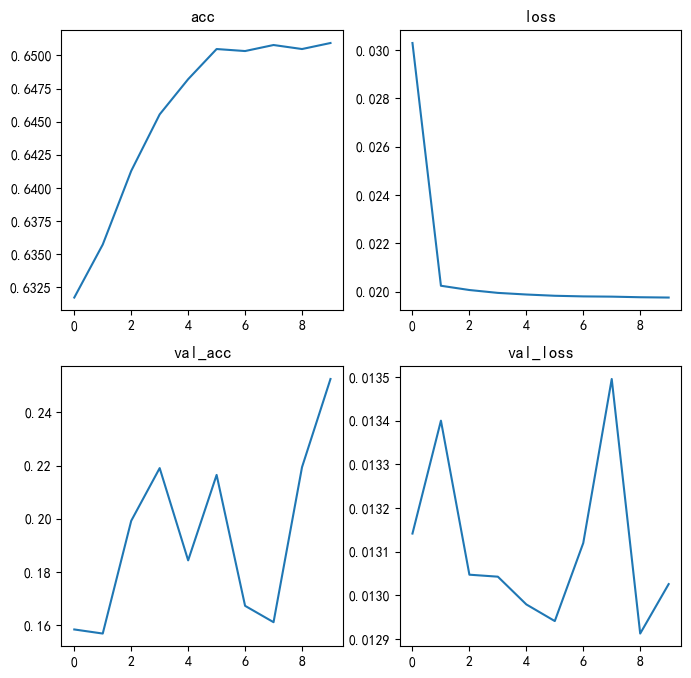

In [161]:
logs = pd.read_csv("./log.csv")

fig, ax = plt.subplots(2,2,figsize=(8,8))
ax[0][0].plot(logs['epoch'],logs['acc'], label='acc')
ax[0][0].set_title('acc')

ax[0][1].plot(logs['epoch'],logs['loss'], label='loss')
ax[0][1].set_title('loss')

ax[1][0].plot(logs['epoch'],logs['val_acc'], label='val_acc')
ax[1][0].set_title('val_acc')

ax[1][1].plot(logs['epoch'],logs['val_loss'], label='val_loss')
ax[1][1].set_title('val_loss')

plt.show()

In [162]:
# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算真实值和预测值偏差的距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

def hav(theta):
    s = np.sin(theta / 2)
    return s * s
#  计算坐标在 WGS84 下的距离
def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance

1/1 [==============================] - 0s 18ms/step
最大值: 1535.823982406547
最小值: 28.919683553059105
均值: 394.6990950582336
方差: 47985.28360025052
标准差: 219.05543499363472
中位数: 365.45549445867357


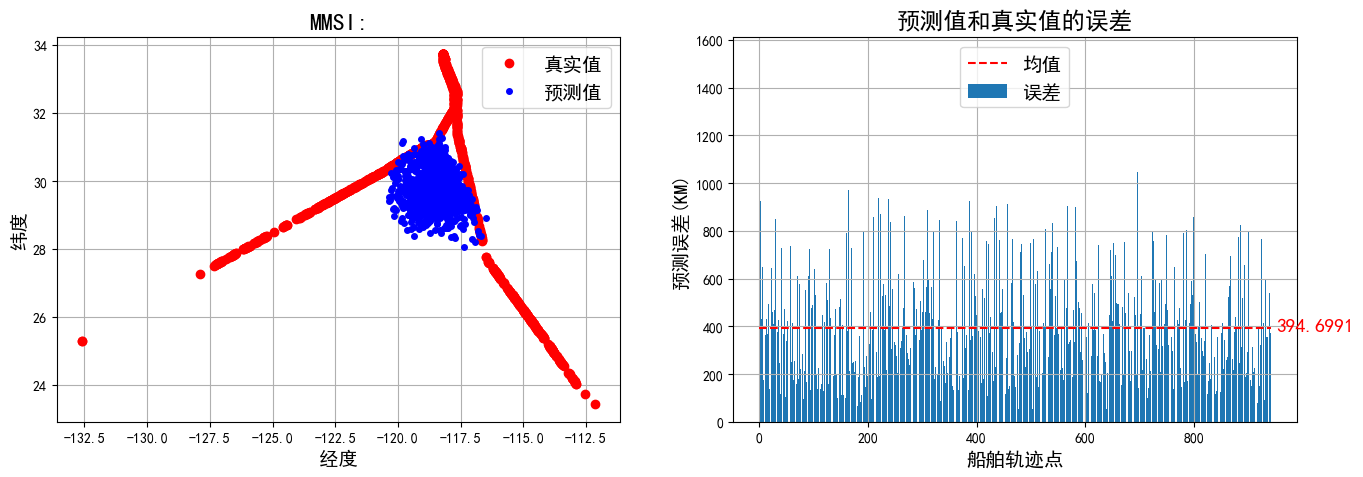

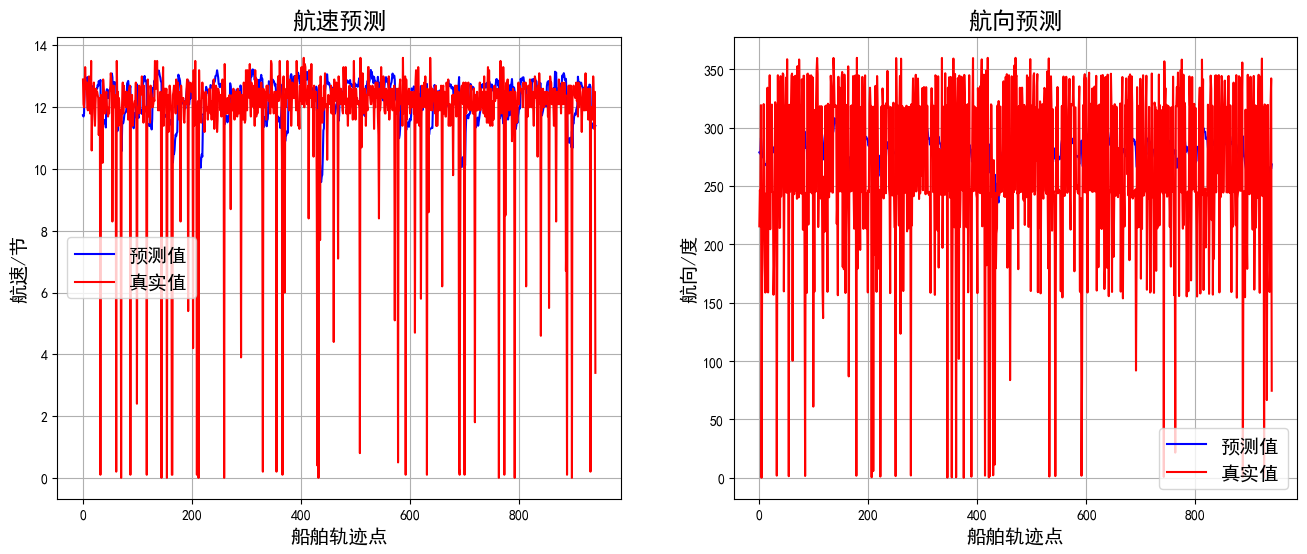

In [163]:
test_points_ids = list(set(test['mmsi']))
model = load_model("./model.h5")
for ids in test_points_ids[:1]:
    y_pre = []
    test_seq, test_label = create_dataset(test.loc[test.mmsi == ids], windows, maxmin)

    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 反归一化
    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 4])}\n最小值: {min(f_y_pre[:, 4])}\n均值: {np.mean(f_y_pre[:, 4])}\n"
          f"方差: {np.var(f_y_pre[:, 4])}\n标准差: {np.std(f_y_pre[:, 4])}\n中位数: {np.median(f_y_pre[:, 4])}")

    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
    bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    plt.title("MMSI:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 4])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 4],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()

1/1 [==============================] - 0s 20ms/step


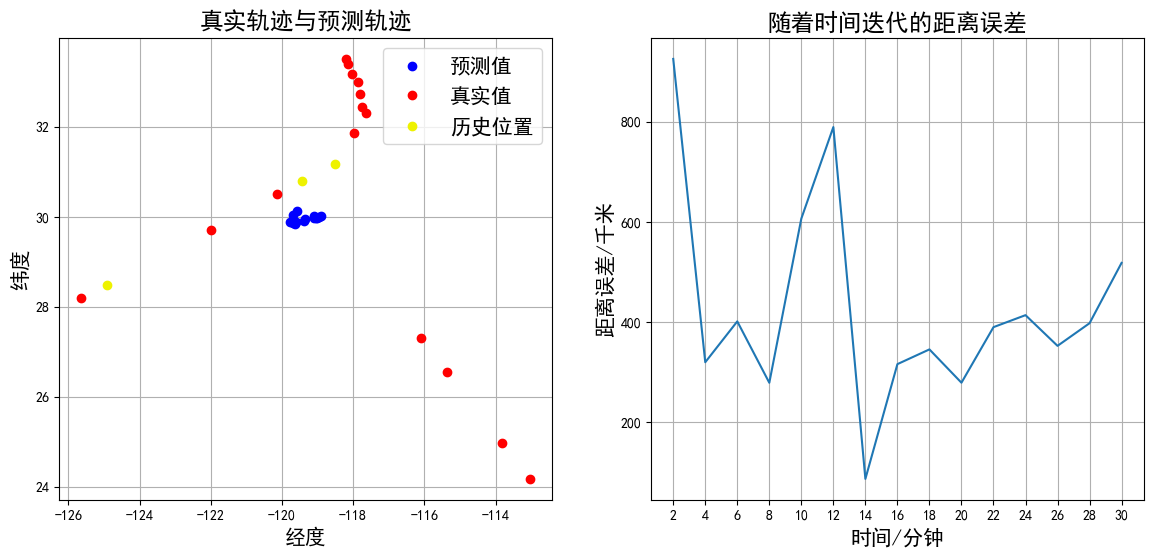

In [164]:
for ids in test_points_ids[:1]:
    test_seq, test_label = create_dataset(test.loc[test.mmsi == ids], windows,maxmin)

    y_pre = []
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 得到真实值
    _,true_lables = FNormalizeMult(y_pre,np.copy(test_label),maxmin)

    # 从第四个开始预测
    for start_id in range(3,4):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        # 最多预测 15 分钟
        maxStep = min(15,test_seq.shape[0] - start_id)
        # 循环预测
        for i in range(maxStep):
            y_hat = model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)

        plt.figure(figsize=(14,6))
        plt.subplot(121)
        plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo", label='预测值')
        plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", label='真实值')
        plt.plot(true_lables[:start_id, 0], true_lables[:start_id, 1], "o",color='#eef200', label='历史位置')
        bounds = [min(f_y_true[:, 0])-0.01,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.01,max(f_y_true[:, 1])+0.01]
        plt.legend(fontsize=15)
        plt.title(f'预测步数量={maxStep},开始位置={start_id}',fontsize=17)
        plt.title(f'真实轨迹与预测轨迹',fontsize=17)
        plt.xlabel("经度",fontsize=15)
        plt.ylabel("纬度",fontsize=15)
        plt.grid()

        plt.subplot(122)
        plt.plot(np.arange(2,2*(maxStep)+1,2),f_y_pre[:,4])
        plt.xticks(np.arange(2,2*(maxStep)+1,2))
        plt.title(f'随着时间迭代的距离误差',fontsize=17)
        plt.xlabel("时间/分钟",fontsize=15)
        plt.ylabel("距离误差/千米",fontsize=15)
        plt.grid()
        plt.show()